# <a id='toc1_'></a>[Bidding engine development](#toc0_)

**Table of contents**<a id='toc0_'></a>    
- [Bidding engine development](#toc1_)    
- [Imports](#toc2_)    
  - [Libraries](#toc2_1_)    
  - [Raw data](#toc2_2_)    
- [Processing](#toc3_)    
  - [Missing values](#toc3_1_)    
    - [Filling with forward fill](#toc3_1_1_)    
    - [Filling with most frequent](#toc3_1_2_)    
    - [Filling with neighbours](#toc3_1_3_)    
  - [Converting object features to numerical](#toc3_2_)    
  - [Scaling metrics features](#toc3_3_)    
  - [Downcasting numerical features](#toc3_4_)    
  - [Dummy variable for broad match modifier](#toc3_5_)    
  - [Profiling interim data](#toc3_6_)    
  - [Add ROI (not used)](#toc3_7_)    
  - [Convert CPC to GBP](#toc3_8_)    
- [Quick look into keywords](#toc4_)    
  - [Unique keyword ids](#toc4_1_)    
  - [Unique keyword ids with positive sessions](#toc4_2_)    
  - [Negative margins](#toc4_3_)    
  - [Most sessions](#toc4_4_)    
  - [Least sessions](#toc4_5_)    
  - [Most impressions](#toc4_6_)    
  - [Least impressions](#toc4_7_)    
- [Processed data](#toc5_)    
  - [Adding Criteria_bmm_ignored](#toc5_1_)    
  - [Profiling processed data](#toc5_2_)    
- [Dataset for forecasting](#toc6_)    
- [Feature importance with SHAP](#toc7_)    
- [Keyword clustering](#toc8_)    
  - [Embedding](#toc8_1_)    
  - [Clustering](#toc8_2_)    
    - [Helper plotters](#toc8_2_1_)    
    - [k-means](#toc8_2_2_)    
    - [Agglomerative](#toc8_2_3_)    
- [Word clouds](#toc9_)    
- [Saving cluster data for forecasting](#toc10_)    
- [Forecasting](#toc11_)    
  - [Bidding dataset class](#toc11_1_)    
  - [LSTM model class](#toc11_2_)    
  - [Early stopping class](#toc11_3_)    
  - [Experiment class](#toc11_4_)    
  - [Parameters](#toc11_5_)    
  - [Model](#toc11_6_)    
  - [Training](#toc11_7_)    
- [Work in progress](#toc12_)    
  - [Visualise clusters with PCA](#toc12_1_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc2_'></a>[Imports](#toc0_)

## <a id='toc2_1_'></a>[Libraries](#toc0_)


In [1]:
import json
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from dotenv import load_dotenv

SEED = 10
np.random.seed(seed=SEED)
load_dotenv()

True

## <a id='toc2_2_'></a>[Raw data](#toc0_)

In [2]:
raw_df = pd.read_feather(
    os.path.join(os.environ['RAW_DATA_PATH'], 'bidding_data.feather'))
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 587593 entries, 0 to 587592
Data columns (total 19 columns):
 #   Column                            Non-Null Count   Dtype         
---  ------                            --------------   -----         
 0   AdGroupId                         587593 non-null  int64         
 1   CampaignId                        587593 non-null  int64         
 2   CriterionId                       587593 non-null  int64         
 3   Date                              587593 non-null  datetime64[ns]
 4   CampaignName                      587593 non-null  object        
 5   AdGroupName                       587593 non-null  object        
 6   Criteria                          587593 non-null  object        
 7   CpcBid                            587593 non-null  float64       
 8   AbsoluteTopImpressionPercentage   587593 non-null  object        
 9   TopImpressionPercentage           587593 non-null  object        
 10  SearchImpressionShare           

In [3]:
raw_df.isna().sum()

AdGroupId                            0
CampaignId                           0
CriterionId                          0
Date                                 0
CampaignName                         0
AdGroupName                          0
Criteria                             0
CpcBid                               0
AbsoluteTopImpressionPercentage      0
TopImpressionPercentage              0
SearchImpressionShare                0
SearchTopImpressionShare             0
SearchRankLostTopImpressionShare     0
Impressions                          0
Clicks                               0
Cost                                39
Sessions                             0
Cost_gbp                             0
Margin                               0
dtype: int64

In [4]:
sum(raw_df.duplicated())

0

In [5]:
raw_df.describe().T.style.background_gradient()

,count,mean,std,min,25%,50%,75%,max
AdGroupId,587593.000000,143500715006.159119,1983820727.708377,138374060766.000000,142284480365.000000,143665829653.000000,143869938197.000000,149054263572.000000
CampaignId,587593.000000,19031107461.691029,2774769.592367,19026016545.000000,19032609979.000000,19032609979.000000,19032615052.000000,19033111187.000000
CriterionId,587593.000000,555324148771.488647,554367670369.387695,10341671.000000,17859937342.000000,325586290788.000000,1162214065887.000000,1906811999272.000000
CpcBid,587593.000000,1496895.483779,783301.658399,84000.000000,972000.000000,1356000.000000,1800000.000000,12768000.000000
Impressions,587593.000000,24.378759,136.797044,0.000000,0.000000,3.000000,14.000000,12901.000000
Clicks,587593.000000,2.589411,16.070534,0.000000,0.000000,0.000000,1.200000,1322.400000
Cost,587554.000000,2624619.354136,18296423.902132,0.000000,0.000000,0.000000,1500000.000000,1754172000.000000
Sessions,587593.000000,2.589270,16.070042,0.000000,0.000000,0.000000,1.200000,1322.400000
Cost_gbp,587593.000000,2.676909,18.660942,0.000000,0.000000,0.000000,1.530000,1789.255439
Margin,587593.000000,1.936043,24.625932,-122.145806,0.000000,0.000000,0.000000,2349.599376


Observations

1. 39 (out of 587,593) NaNs in `Cost` column. Nans rows can be dropped due to insignificant amount. Alternatively, can interpolated (forward fill) or imputed.

2. The following columns could be converted to numerical (floats) judging by the `.head()` and columns names
```
8   AbsoluteTopImpressionPercentage   587593 non-null  object        
9   TopImpressionPercentage           587593 non-null  object        
10  SearchImpressionShare             587593 non-null  object        
11  SearchTopImpressionShare          587593 non-null  object        
12  SearchRankLostTopImpressionShare  587593 non-null  object        
```

# <a id='toc3_'></a>[Processing](#toc0_)

In [6]:
interim_df = raw_df.copy(deep=True)
interim_df_sorted = interim_df.sort_values(
    by=['CriterionId', 'Date']).reset_index(drop=True)


In [7]:
def plot_keyword(df: pd.DataFrame, criterion: int, features: list) -> None:
    '''
    The plot_keyword function takes a dataframe, criterion ID, and list of features to plot.
    It then plots the specified features for the given criterion ID.
    
    Parameters
    ----------
        df
            Pass the dataframe to the function
        criterion
            Select the keyword to plot
        features
            Specify which columns to plot
    '''
    for feature in features:
        plt.plot(df.loc[df['CriterionId'] == criterion, 'Date'],
                 df.loc[df['CriterionId'] == criterion, feature],
                 label=feature)
    plt.title('Keyword ID {}\nUnique keywords {}'.format(
        criterion, raw_df.loc[raw_df['CriterionId'] == criterion,
                              'Criteria'].unique()))
    plt.xticks(rotation=45)
    if len(features) == 1:
        plt.ylabel(feature)
    else:
        plt.legend()
    plt.show()

In [8]:
def plot_filled(df: pd.DataFrame, criterion: int, features: list) -> None:
    '''
    The plot_filled function takes a dataframe, criterion ID, and list of features as input.
    It then plots the filled values for each feature in the list against the date.
    If there is only one feature in the list, it labels that axis with that feature name.
    
    Parameters
    ----------
        df
            Pass the dataframe to the function
        criterion
            Filter the dataframe to only show the rows that have a criterionid equal to criterion
        features
            Specify which columns to plot
    '''
    from matplotlib.markers import MarkerStyle

    markers = list(MarkerStyle.markers.keys())[1:len(features) + 1]
    plt.figure()
    for feature, marker in zip(features, markers):
        if 'filled' in feature:
            plt.plot(df.loc[(df['CriterionId'] == criterion)
                            & (df['Cost'].isna()), 'Date'],
                     df.loc[(df['CriterionId'] == criterion) &
                            (df['Cost'].isna()), feature],
                     marker,
                     label=feature)
        else:
            plt.plot(df.loc[df['CriterionId'] == criterion, 'Date'],
                     df.loc[df['CriterionId'] == criterion, feature],
                     label=feature)
    plt.title('Keyword ID {}\nUnique keywords {}'.format(
        criterion,
        df.sort_values(
            by=['CriterionId', 'Date']).loc[df['CriterionId'] == criterion,
                                            'Criteria'].unique()))
    plt.xticks(rotation=45)
    if len(features) == 1:
        plt.ylabel(feature)
    else:
        plt.legend()
    plt.show()

## <a id='toc3_1_'></a>[Missing values](#toc0_)

In [9]:
missing_criterionids = raw_df.loc[raw_df['Cost'].isnull(),
                                  'CriterionId'].unique()
print(f'unique keywords with missing values: {len(missing_criterionids)}')

unique keywords with missing values: 39


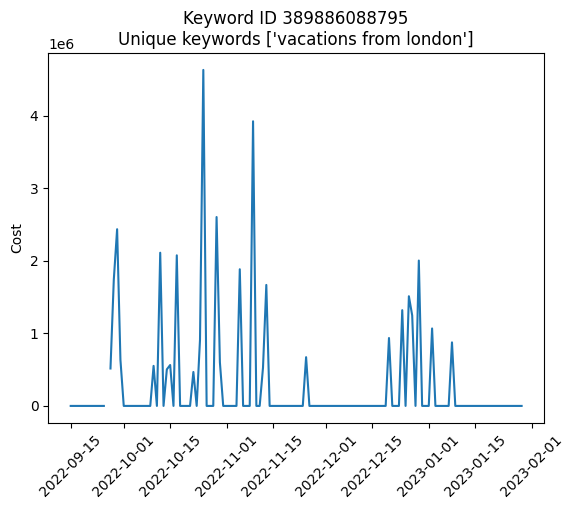

In [10]:
random_criterion_with_missing_cost = np.random.choice(missing_criterionids)
features = ['Cost']
plot_keyword(df=interim_df_sorted,
             criterion=random_criterion_with_missing_cost,
             features=features)


### <a id='toc3_1_1_'></a>[Filling with forward fill](#toc0_)

In [11]:
interim_df_sorted['Cost_forward_filled'] = interim_df_sorted[
    'Cost'].interpolate(method='ffill')


### <a id='toc3_1_2_'></a>[Filling with most frequent](#toc0_)

In [12]:
from sklearn.impute import SimpleImputer

frequency_imp = SimpleImputer(strategy='most_frequent')
interim_df_sorted['Cost_frequency_filled'] = interim_df_sorted['Cost'].copy(
    deep=True)
for criterion in missing_criterionids:
    interim_df_sorted.loc[
        interim_df_sorted['CriterionId'] == criterion,
        'Cost_frequency_filled'] = frequency_imp.fit_transform(
            interim_df_sorted.loc[
                interim_df_sorted['CriterionId'] == criterion,
                'Cost_frequency_filled'].values.reshape(-1, 1)).reshape(-1)

In [13]:
interim_df_sorted['Cost_mode_filled'] = interim_df_sorted['Cost'].copy(
    deep=True)
modes = []
for criterion in missing_criterionids:
    mode = interim_df_sorted.loc[interim_df_sorted['CriterionId'] == criterion,
                                 'Cost_mode_filled'].mode().values[0]
    interim_df_sorted.loc[interim_df_sorted['CriterionId'] == criterion,
                          'Cost_mode_filled'] = interim_df_sorted.loc[
                              interim_df_sorted['CriterionId'] == criterion,
                              'Cost_mode_filled'].fillna(value=mode)
    modes.append(mode)


### <a id='toc3_1_3_'></a>[Filling with neighbours](#toc0_)

In [14]:
from sklearn.impute import KNNImputer

knn_imp = KNNImputer(n_neighbors=5, weights='distance')
interim_df_sorted['Cost_knn_filled'] = interim_df_sorted['Cost'].copy(
    deep=True)
for criterion in missing_criterionids:
    interim_df_sorted.loc[
        interim_df_sorted['CriterionId'] == criterion,
        'Cost_knn_filled'] = knn_imp.fit_transform(interim_df_sorted.loc[
            interim_df_sorted['CriterionId'] == criterion,
            'Cost_knn_filled'].values.reshape(-1, 1)).reshape(-1)

Comparison of the filling methods on the random keyword

In [15]:
filled = interim_df_sorted.loc[interim_df_sorted['Cost'].isna(), [
    'Cost', 'Cost_knn_filled', 'Cost_forward_filled', 'Cost_frequency_filled',
    'Cost_mode_filled'
]]


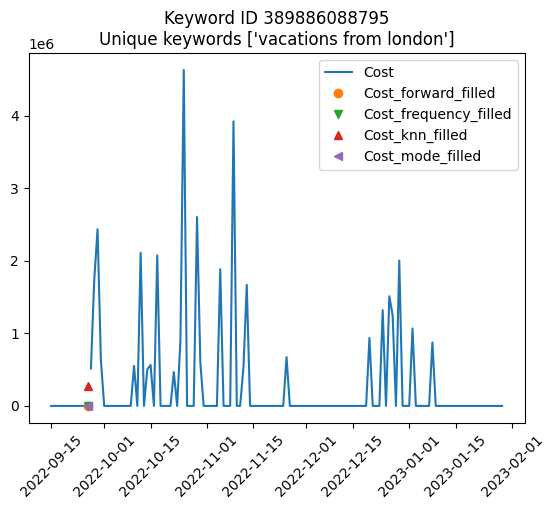

keyword 1592345682. mode: 0.0


In [16]:
plot_filled(
    df=interim_df_sorted,
    #   uncomment to see filling on a random keyword
    # criterion=np.random.choice(missing_criterionids),
    #   uncomment below to see filing on the same keyword as above
    criterion=random_criterion_with_missing_cost,
    features=[
        'Cost', 'Cost_forward_filled', 'Cost_frequency_filled',
        'Cost_knn_filled', 'Cost_mode_filled'
    ])
print('keyword {}. mode: {}'.format(
    criterion,
    interim_df_sorted.loc[interim_df_sorted['CriterionId'] == criterion,
                          'Cost'].mode()[0]))


Conclusion on filling NaNs

Due to sparsity of the data, filling with the most frequent (mode) per keyword value was chosen

In [17]:
interim_df_sorted_no_nans = interim_df_sorted.copy(deep=True)
interim_df_sorted_no_nans['Cost'] = interim_df_sorted_no_nans[
    'Cost_frequency_filled']
interim_df_sorted_no_nans.drop(
    columns=[
        # 'Cost_forward_filled',
        'Cost_frequency_filled',
        # 'Cost_knn_filled',
        # 'Cost_mode_filled',
    ],
    inplace=True)


## <a id='toc3_2_'></a>[Converting object features to numerical](#toc0_)

In [18]:
interim_df_sorted['Cost_mode_filled'] = interim_df_sorted['Cost'].copy(
    deep=True)
modes = []
for criterion in missing_criterionids:
    mode = interim_df_sorted.loc[interim_df_sorted['CriterionId'] == criterion,
                                 'Cost_mode_filled'].mode().values[0]
    interim_df_sorted.loc[interim_df_sorted['CriterionId'] == criterion,
                          'Cost_mode_filled'] = interim_df_sorted.loc[
                              interim_df_sorted['CriterionId'] == criterion,
                              'Cost_mode_filled'].fillna(value=mode)
    modes.append(mode)

## <a id='toc3_3_'></a>[Scaling metrics features](#toc0_)

See the ranges of metrics in [Google Ad API](https://developers.google.com/google-ads/api/fields/v11/metrics)

In [19]:
object_columns = [
        'AbsoluteTopImpressionPercentage', 'TopImpressionPercentage',
        'SearchImpressionShare', 'SearchTopImpressionShare',
        'SearchRankLostTopImpressionShare'
    ]
for col in object_columns:
    interim_df_sorted_no_nans[col] = (interim_df_sorted_no_nans[col] -
                                      interim_df_sorted_no_nans[col].min()
                                      ) / interim_df_sorted_no_nans[col].max()
    if 'Percentage' in col:
        interim_df_sorted_no_nans[col] *= 100

## <a id='toc3_4_'></a>[Downcasting numerical features](#toc0_)

In [20]:
fcols = interim_df_sorted_no_nans.select_dtypes('float').columns
icols = interim_df_sorted_no_nans.select_dtypes('integer').columns

interim_df_sorted_no_nans[fcols] = interim_df_sorted_no_nans[fcols].apply(
    pd.to_numeric, downcast='float')
interim_df_sorted_no_nans[icols] = interim_df_sorted_no_nans[icols].apply(
    pd.to_numeric, downcast='integer')


## <a id='toc3_5_'></a>[Dummy variable for broad match modifier](#toc0_)

For the same index, AdGroupName can contain BMM in the name, but Criteria may not include it. '+' in Criteria is prevailing

In [21]:
interim_df_sorted_no_nans['BMM'] = interim_df_sorted_no_nans[
    'Criteria'].str.contains('+', regex=False).astype(np.int8)


In [22]:
all(interim_df_sorted_no_nans['Criteria'].str.islower())

True

## <a id='toc3_6_'></a>[Profiling interim data](#toc0_)

In [23]:
if 'interim_data.html' not in os.listdir(os.environ['DATA_PROFILES_PATH']):
    from ydata_profiling import ProfileReport

    os.makedirs(os.environ['DATA_PROFILES_PATH'], exist_ok=True)
    interim_data_profile = ProfileReport(interim_df_sorted_no_nans,
                                         title='Interim Data Profile')
    interim_data_profile.to_file(
        os.path.join(os.environ['DATA_PROFILES_PATH'], 'interim_data.html'))
    del interim_data_profile


## <a id='toc3_7_'></a>[Add ROI (not used)](#toc0_)

In [24]:
# interim_df_sorted_no_nans['ROI_gbp'] = interim_df_sorted_no_nans[
#     'Margin'].divide(interim_df_sorted_no_nans['Cost_gbp'],
#                      fill_value=0).replace({
#                          np.inf: 0,
#                          np.nan: 0
#                      })
# interim_df_sorted_no_nans['ROI'] = interim_df_sorted_no_nans['Margin'].divide(
#     interim_df_sorted_no_nans['Cost'], fill_value=0).replace({
#         np.inf: 0,
#         np.nan: 0
#     })


## <a id='toc3_8_'></a>[Convert CPC to GBP](#toc0_)

In [25]:
micros_to_gbp = interim_df_sorted_no_nans['Cost'].div(
    interim_df_sorted_no_nans['Cost_gbp']).replace({
        np.nan: 0,
        np.inf: 0
    }).unique()[1:].mean()


In [26]:
interim_df_sorted_no_nans[
    'CpcBid_gbp'] = interim_df_sorted_no_nans['CpcBid'] / micros_to_gbp


# <a id='toc4_'></a>[Quick look into keywords](#toc0_)

## <a id='toc4_1_'></a>[Unique keyword ids](#toc0_)

In [27]:
len(interim_df_sorted_no_nans['CriterionId'].unique())

4320

## <a id='toc4_2_'></a>[Unique keyword ids with positive sessions](#toc0_)

In [28]:
len(interim_df_sorted_no_nans.loc[(interim_df_sorted_no_nans['Margin'] > 0) &
                                  (interim_df_sorted_no_nans['Sessions'] > 0),
                                  'CriterionId'].unique())


2503

## <a id='toc4_3_'></a>[Negative margins](#toc0_)

In [29]:
negative_margins = interim_df_sorted_no_nans.loc[
    interim_df_sorted_no_nans['Margin'] < 0, 'CriterionId'].unique()


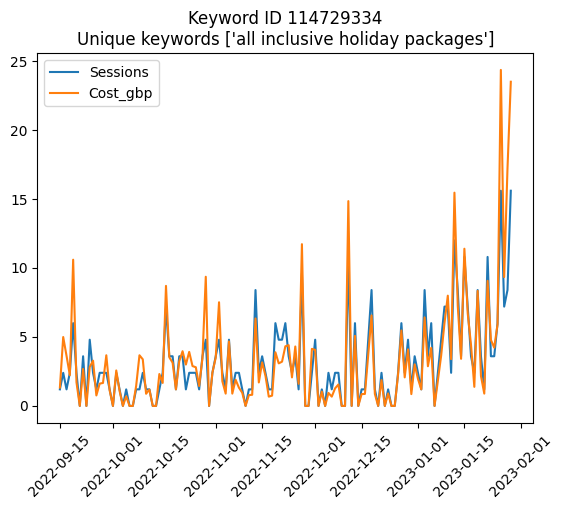

Negative margins: [-2.7061143] at 13137    2023-01-15
Name: Date, dtype: object


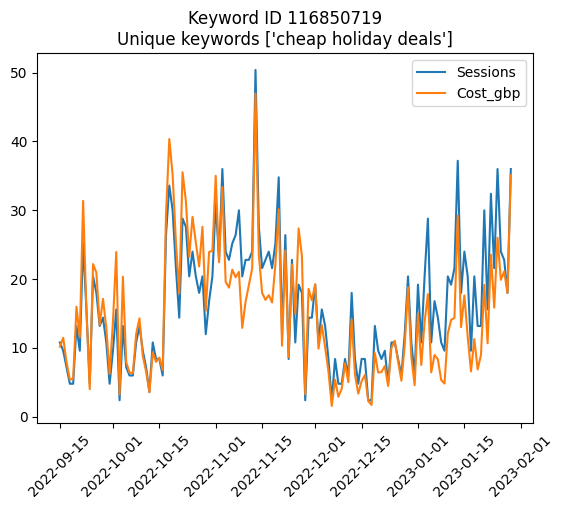

Negative margins: [-6.271931] at 13583    2022-10-05
Name: Date, dtype: object


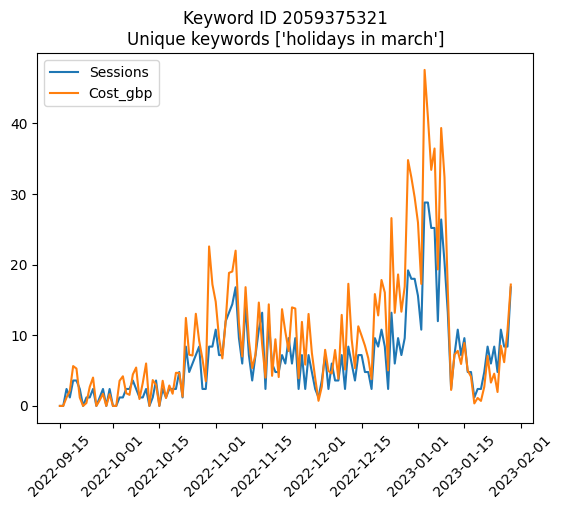

Negative margins: [-0.45185876] at 75498    2023-01-16
Name: Date, dtype: object


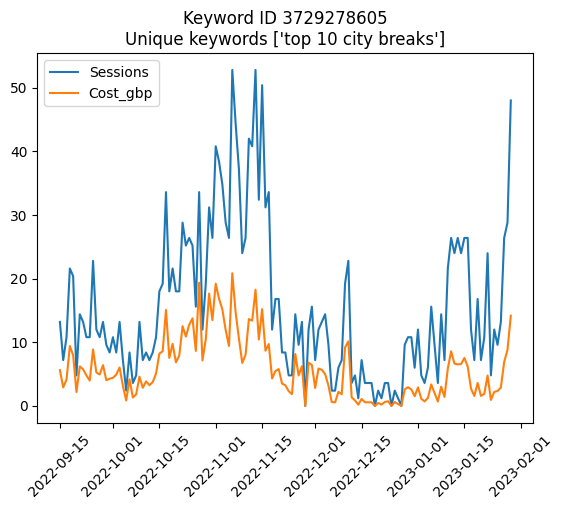

Negative margins: [-4.7134953] at 91468    2022-11-18
Name: Date, dtype: object


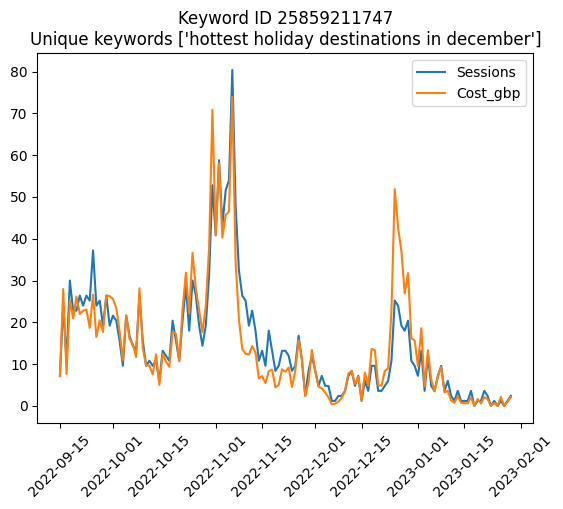

Negative margins: [-3.6482835] at 155021    2022-11-03
Name: Date, dtype: object


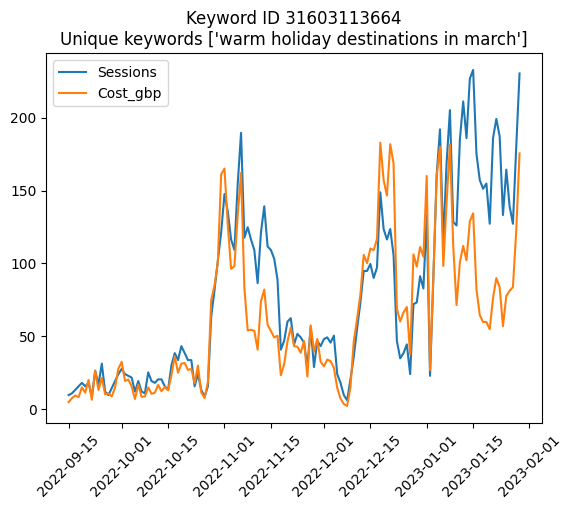

Negative margins: [-122.145805] at 160649    2023-01-27
Name: Date, dtype: object


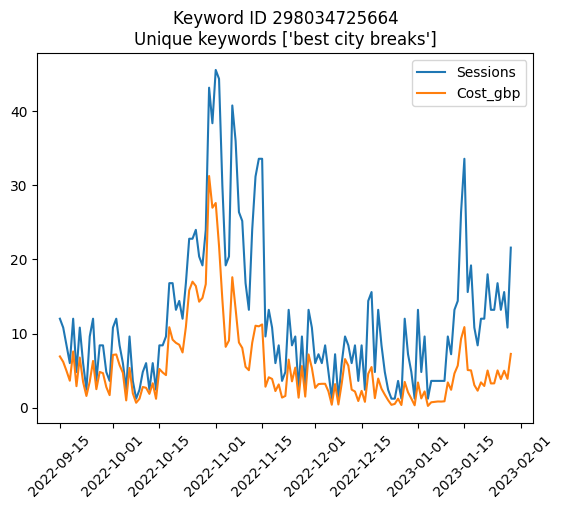

Negative margins: [-2.761438] at 196044    2023-01-24
Name: Date, dtype: object


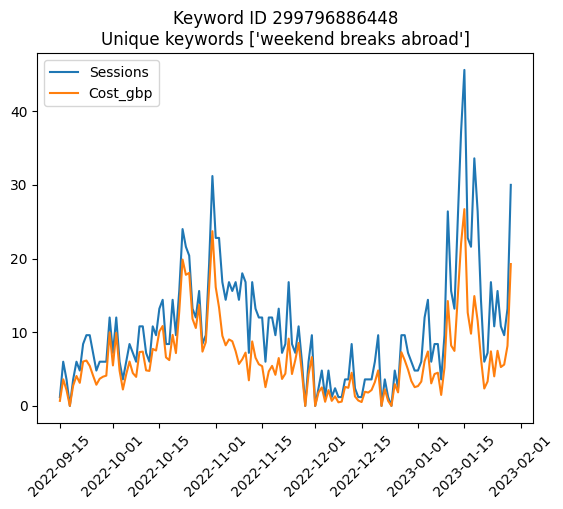

Negative margins: [-19.80198] at 203929    2022-11-24
Name: Date, dtype: object


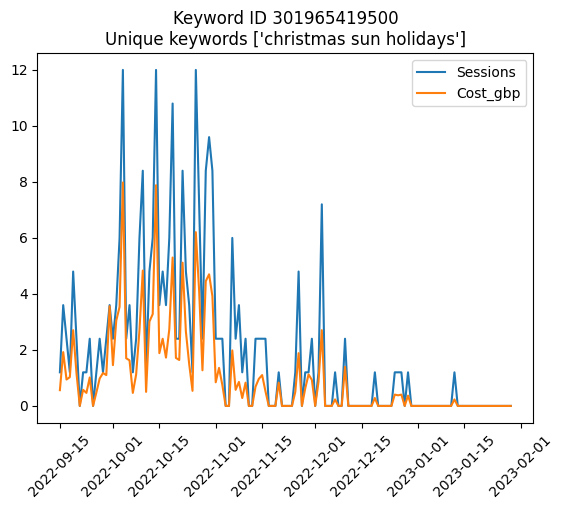

Negative margins: [-1.2024386] at 212946    2022-10-30
Name: Date, dtype: object


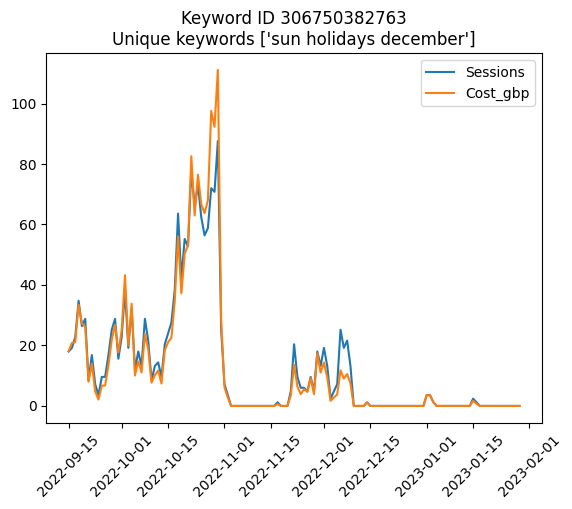

Negative margins: [-0.14227723] at 228796    2022-12-01
Name: Date, dtype: object


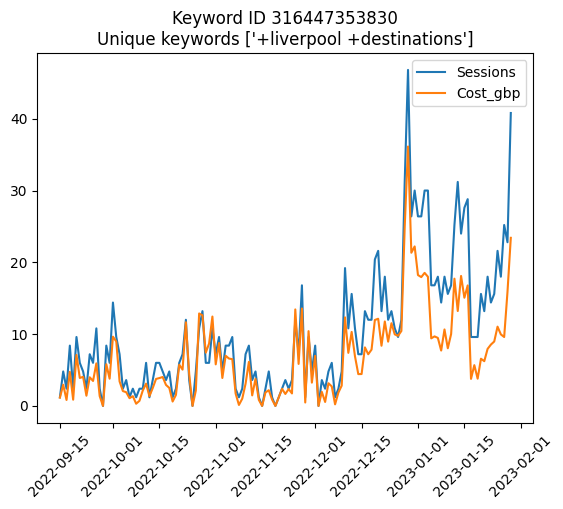

Negative margins: [-83.62362] at 255076    2022-09-16
Name: Date, dtype: object


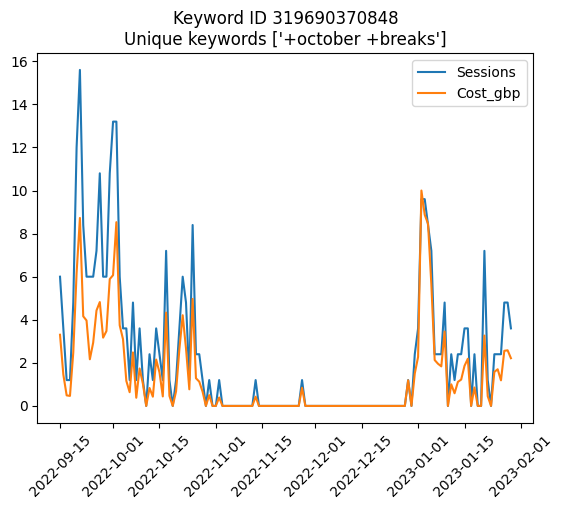

Negative margins: [-83.43191] at 278270    2022-09-16
Name: Date, dtype: object


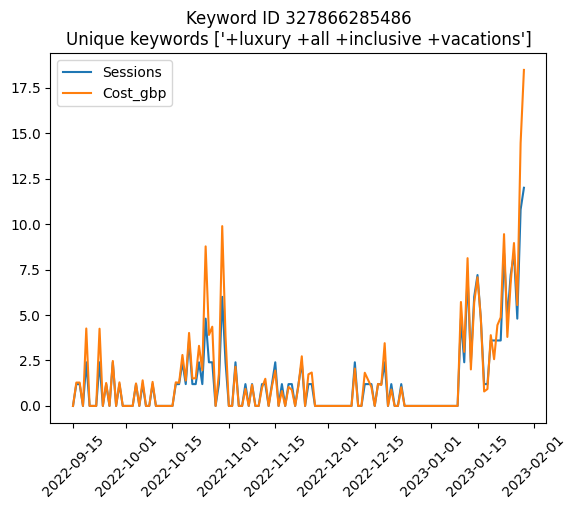

Negative margins: [-1.1051224] at 298042    2022-10-30
Name: Date, dtype: object


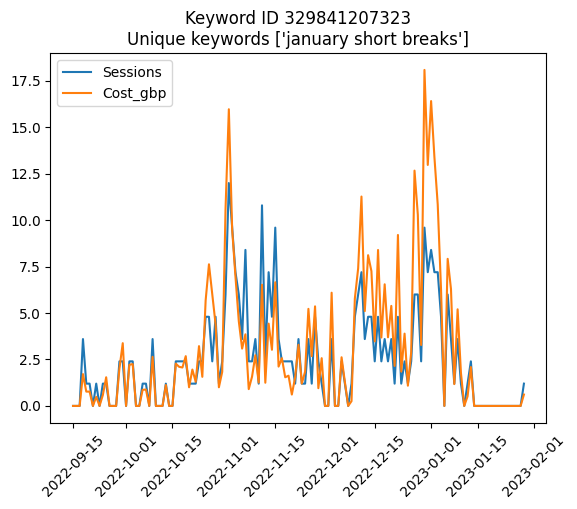

Negative margins: [-0.5656506] at 301358    2022-11-27
Name: Date, dtype: object


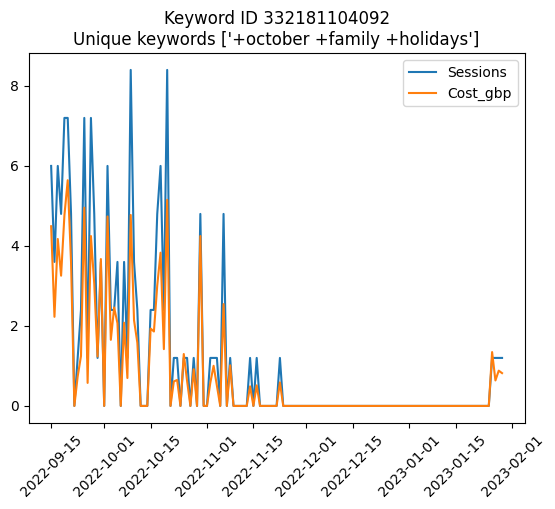

Negative margins: [-83.52625] at 307267    2022-09-16
Name: Date, dtype: object


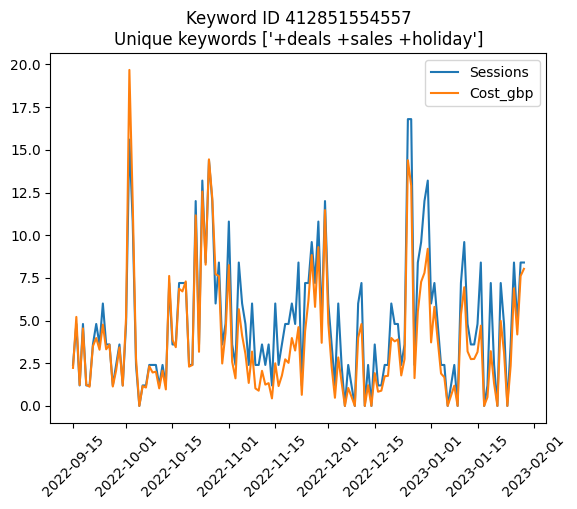

Negative margins: [-1.4543619] at 374282    2022-09-15
Name: Date, dtype: object


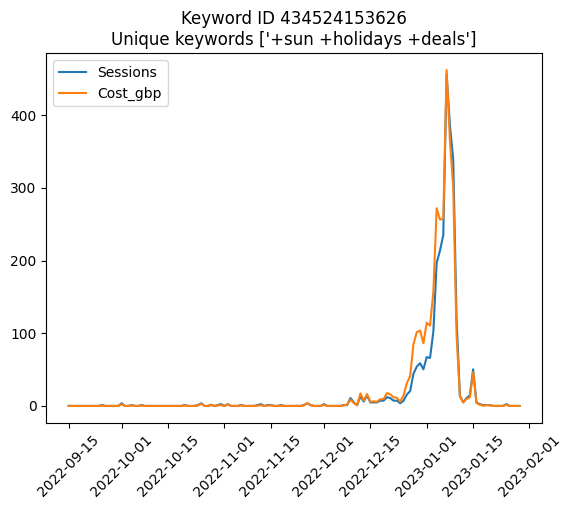

Negative margins: [-16.082891] at 376181    2023-01-11
Name: Date, dtype: object


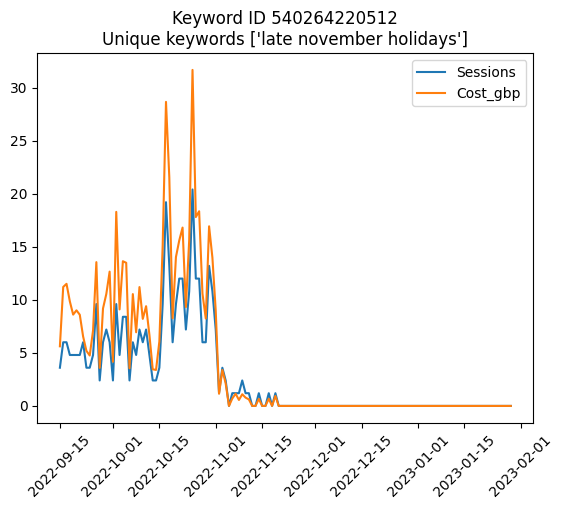

Negative margins: [-9.85948] at 383785    2022-11-04
Name: Date, dtype: object


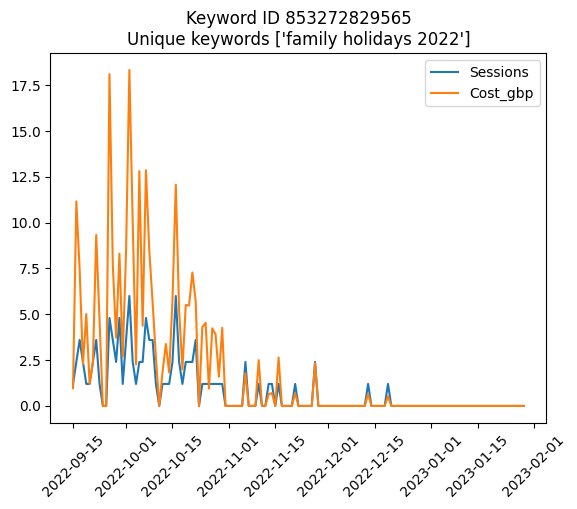

Negative margins: [-29.416378] at 397171    2022-10-17
Name: Date, dtype: object


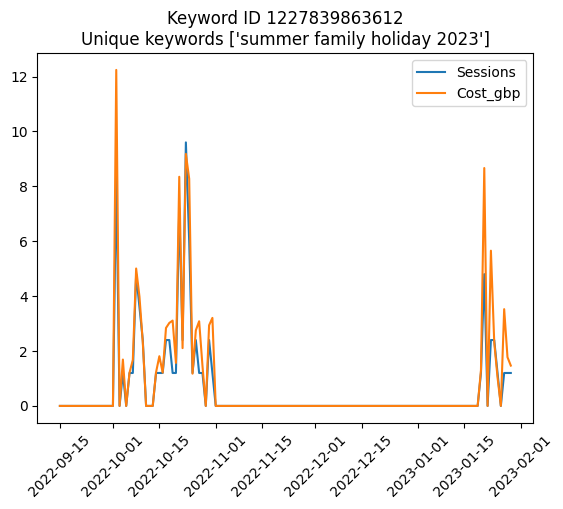

Negative margins: [-1.0710093] at 534863    2022-10-30
Name: Date, dtype: object


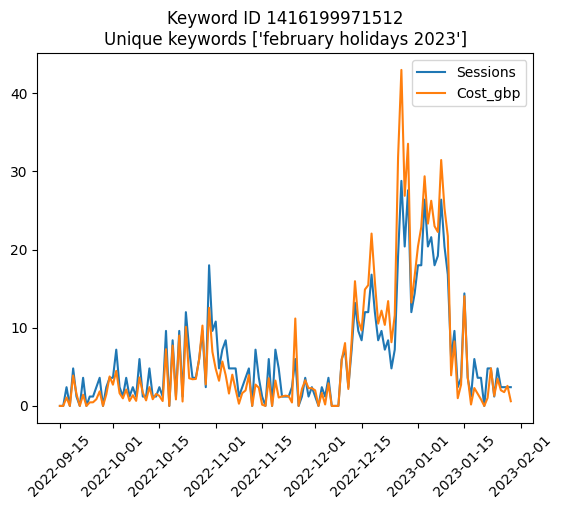

Negative margins: [-32.880077] at 546378    2023-01-19
Name: Date, dtype: object


In [30]:
for criterion in negative_margins:
    plot_keyword(df=interim_df_sorted_no_nans,
                 criterion=criterion,
                 features=['Sessions', 'Cost_gbp'])
    print('Negative margins: {} at {}'.format(
        interim_df_sorted_no_nans.loc[
            (interim_df_sorted_no_nans['CriterionId'] == criterion) &
            (interim_df_sorted_no_nans['Margin'] < 0), 'Margin'].values,
        interim_df_sorted_no_nans.loc[
            (interim_df_sorted_no_nans['CriterionId'] == criterion) &
            (interim_df_sorted_no_nans['Margin'] < 0), 'Date'].dt.date))


In this context, the negative margins are unlikely to mean loss. Apply abs() to margins

In [31]:
interim_df_sorted_no_nans['Margin'] = abs(interim_df_sorted_no_nans['Margin'])

## <a id='toc4_4_'></a>[Most sessions](#toc0_)

In [32]:
most_sessions = interim_df_sorted_no_nans.sort_values(
    by=['Sessions'],
    ascending=False).loc[interim_df_sorted_no_nans['Margin'] > 0,
                         'CriterionId'][:75].unique()
print(most_sessions)
interim_df_sorted_no_nans.loc[
    interim_df_sorted_no_nans['CriterionId'].isin(most_sessions),
    'Criteria'].unique()

[1161551891012 1210258704454      28171120  371829061397 1224358859975
 1058788934121]


array(['city breaks', '+half +term +holidays',
       'all inclusive holidays 2023', 'holidays 2023',
       'cheap holidays 2023', 'easter holidays 2023'], dtype=object)

## <a id='toc4_5_'></a>[Least sessions](#toc0_)

In [33]:
least_sessions = interim_df_sorted_no_nans.sort_values(
    by=['Sessions'], ascending=True)['CriterionId'].unique()[:10]
print(least_sessions)
interim_df_sorted_no_nans.loc[
    interim_df_sorted_no_nans['CriterionId'].isin(least_sessions),
    'Criteria'].unique()

[    10341671 374901682957 374477784176 376861730083 373125841645
 373023664447 372921549487 383313093317 383321717437 383306041437]


array(['winter vacations', '+single +group +holidays',
       '+cheap +holidays +summer', 'holiday deals late', 'feb vacations',
       'very cheap holidays abroad all inclusive',
       'lads package holidays', '+summer +bargain +holidays',
       '+cheap +discount +holidays', '+cheap +self +catering +holiday'],
      dtype=object)

## <a id='toc4_6_'></a>[Most impressions](#toc0_)

In [34]:
most_impressions = interim_df_sorted_no_nans.sort_values(
    by=['Impressions'], ascending=False)['CriterionId'].unique()[:10]
print(most_impressions)
interim_df_sorted_no_nans.loc[
    interim_df_sorted_no_nans['CriterionId'].isin(most_impressions),
    'Criteria'].unique()

[ 371829061397 1109001687720 1224358859975 1161551891012  305548399133
  303054917163      28171120     674372683  434524153626 1210258704454]


array(['city breaks', 'xmas markets', '+new +years +holidays',
       '+new years +vacations', '+half +term +holidays',
       '+sun +holidays +deals', '+holidays +new +year +2022',
       'holidays 2023', 'cheap holidays 2023', 'easter holidays 2023'],
      dtype=object)

## <a id='toc4_7_'></a>[Least impressions](#toc0_)

In [35]:
least_impressions = interim_df_sorted_no_nans.sort_values(
    by=['Impressions'], ascending=True)['CriterionId'].unique()[:10]
print(least_impressions)
interim_df_sorted_no_nans.loc[
    interim_df_sorted_no_nans['CriterionId'].isin(least_impressions),
    'Criteria'].unique()

[325586290788 352388655012 352388653892 352395524543 350271886521
 351428853727 352078257487 352388653652 354676326914 354566414810]


array(['+cheap +holidays +villa', 'holidays from inverness',
       '+bargain +hotel', '+hotel +5 +star', '+break +easter +holiday',
       '+deals +easter +holiday', 'break easter holidays',
       'half term october holidays', '5 star all inclusive vacations',
       'villa holidays for large groups'], dtype=object)

# <a id='toc5_'></a>[Processed data](#toc0_)

In [36]:
os.makedirs(os.environ['INTERIM_DATA_PATH'], exist_ok=True)
if 'interim_data.feather' not in os.listdir(os.environ['INTERIM_DATA_PATH']):
    interim_df_sorted_no_nans.to_feather(
        os.path.join(os.environ['INTERIM_DATA_PATH'], 'interim_data.feather'))


In [37]:
processed_df = interim_df_sorted_no_nans.copy(deep=True)
fcols = processed_df.select_dtypes('float').columns.to_list()

In [38]:
processed_df = processed_df[
    ['CriterionId', 'Criteria', 'Date', 'Impressions', 'BMM'] + fcols]


In [39]:
processed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 587593 entries, 0 to 587592
Data columns (total 20 columns):
 #   Column                            Non-Null Count   Dtype         
---  ------                            --------------   -----         
 0   CriterionId                       587593 non-null  int64         
 1   Criteria                          587593 non-null  object        
 2   Date                              587593 non-null  datetime64[ns]
 3   Impressions                       587593 non-null  int16         
 4   BMM                               587593 non-null  int8          
 5   CpcBid                            587593 non-null  float32       
 6   AbsoluteTopImpressionPercentage   587593 non-null  float32       
 7   TopImpressionPercentage           587593 non-null  float32       
 8   SearchImpressionShare             587593 non-null  float32       
 9   SearchTopImpressionShare          587593 non-null  float32       
 10  SearchRankLostTopImpressionShare

## <a id='toc5_1_'></a>[Adding Criteria_bmm_ignored](#toc0_)

In [40]:
processed_df['Criteria_bmm_ignored'] = processed_df['Criteria'].str.replace(
    r'[^\w\s]+', '', regex=True)


## <a id='toc5_2_'></a>[Profiling processed data](#toc0_)

In [41]:
if 'processed_data.html' not in os.listdir(os.environ['DATA_PROFILES_PATH']):
    from ydata_profiling import ProfileReport

    os.makedirs(os.environ['DATA_PROFILES_PATH'], exist_ok=True)
    processed_data_profile = ProfileReport(processed_df,
                                           title='Processed Data Profile')
    processed_data_profile.to_file(
        os.path.join(os.environ['DATA_PROFILES_PATH'], 'processed_data.html'))
    del processed_data_profile

In [42]:
os.makedirs(os.environ['PROCESSED_DATA_PATH'], exist_ok=True)
if 'processed_data.feather' not in os.listdir(os.environ['INTERIM_DATA_PATH']):
    interim_df_sorted_no_nans.to_feather(
        os.path.join(os.environ['PROCESSED_DATA_PATH'],
                     'processed_data.feather'))


# <a id='toc6_'></a>[Dataset for forecasting](#toc0_)

In [43]:
features = [
    'Impressions',
    'AbsoluteTopImpressionPercentage',
    'TopImpressionPercentage',
    'SearchImpressionShare',
    'SearchTopImpressionShare',
    'SearchRankLostTopImpressionShare',
    'Clicks',
    'Cost_gbp',
    'CpcBid_gbp',
]
features_date = features + ['Date']
target = 'CpcBid_gbp'
features.remove(target)

In [44]:
dates = processed_df['Date'].dt.date.unique()

# <a id='toc7_'></a>[Feature importance with SHAP](#toc0_)

In [45]:
import xgboost
import shap

X, y = processed_df[features], processed_df[target]
model = xgboost.XGBRegressor().fit(X, y)
explainer = shap.Explainer(model)
shap_values = explainer(X)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


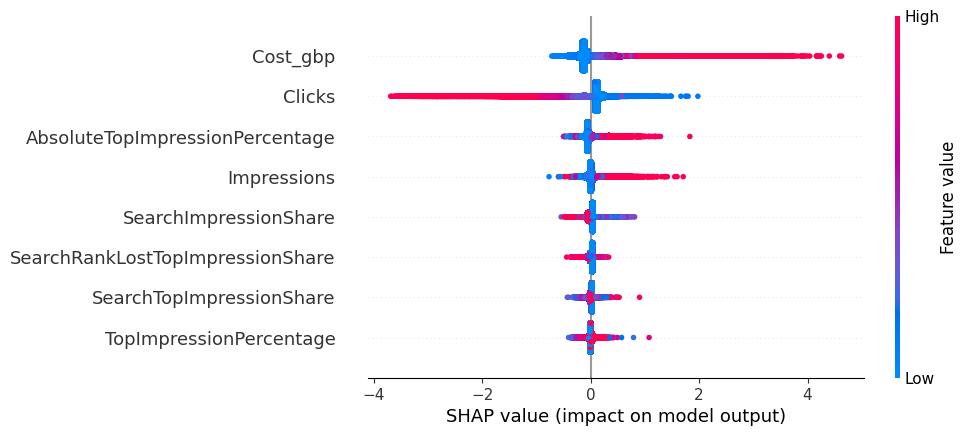

In [46]:
shap.plots.beeswarm(shap_values)

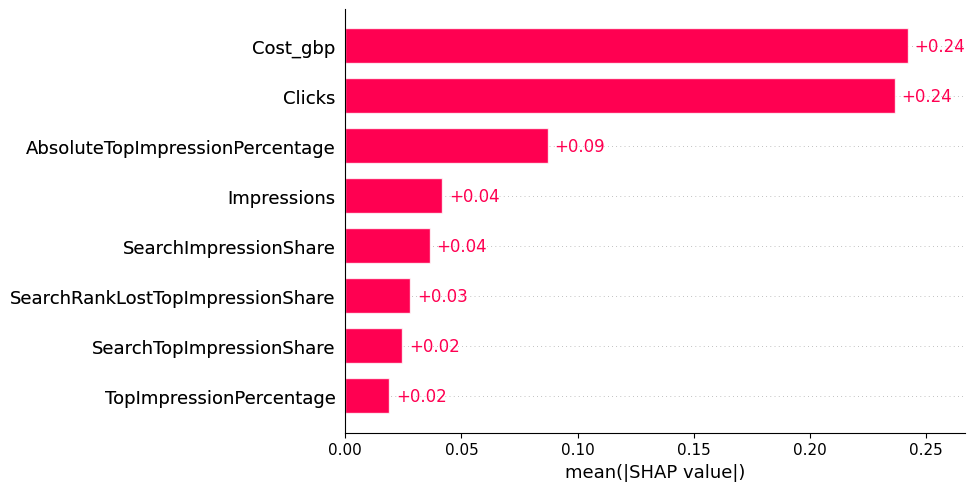

In [47]:
shap.plots.bar(shap_values)

# <a id='toc8_'></a>[Keyword clustering](#toc0_)

## <a id='toc8_1_'></a>[Embedding](#toc0_)

In [48]:
kwds = processed_df['Criteria'].unique()
print(len(kwds))
kwds

4262


array(['winter vacations', 'cheap hotels', 'short beach breaks', ...,
       'christmas break 2024', 'package holidays 2024',
       'party holidays 2024'], dtype=object)

In [49]:
kwds_no_bmm = processed_df['Criteria_bmm_ignored'].unique()
print(len(kwds_no_bmm))
kwds_no_bmm

3394


array(['winter vacations', 'cheap hotels', 'short beach breaks', ...,
       'christmas break 2024', 'package holidays 2024',
       'party holidays 2024'], dtype=object)

In [50]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-MiniLM-L6-v1')

kwds_embeddings = model.encode(kwds_no_bmm)
kwds_embeddings.shape

(3394, 384)

## <a id='toc8_2_'></a>[Clustering](#toc0_)

### <a id='toc8_2_1_'></a>[Helper plotters](#toc0_)

In [51]:
def get_clusters(clusters: np.ndarray,
                 return_clustered: bool = False,
                 print_clusters: bool = False) -> None | dict:
    """
    The get_clusters function takes the clusters array and returns a dictionary of keywords,
    where each keyword is associated with its cluster number. The function also prints out the 
    clusters if print_clusters is set to True. If return_clustered is set to True, then it will 
    return a dictionary of clusters instead of printing them.
    
    Parameters
    ----------
        clusters: np.ndarray
            Pass the array of cluster ids
        return_clustered: bool
            Return the clustered dictionary
        print_clusters: bool
            Print the clusters
    
    Returns
    -------
    
        A dictionary with the cluster ids as keys and lists of keywords in that cluster as values
    """
    clustered = {}
    for i, cluster_id in enumerate(clusters):
        if cluster_id not in clustered:
            clustered[int(cluster_id)] = []
        clustered[int(cluster_id)].append(kwds_no_bmm[i])
    if print_clusters:
        for i, kw in sorted(clustered.items()):
            print('Cluster {}, {} elements\n{}\n'.format(i + 1, len(kw), kw))

    if return_clustered:
        return dict(sorted(clustered.items()))

### <a id='toc8_2_2_'></a>[k-means](#toc0_)

In [52]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize

n_clusters = 8
kmeans_model = KMeans(n_clusters=n_clusters,
                      max_iter=500,
                      n_init=100,
                      init='k-means++',
                      random_state=SEED)
kmeans_model.fit(normalize(kwds_embeddings))
kmeans_clusters = kmeans_model.labels_

In [53]:
kmeans_clustered = get_clusters(kmeans_clusters,
                                return_clustered=True,
                                print_clusters=False)
with open(
        os.path.join(os.environ['MODELS_PATH'], 'kmeans_clustered_dict.json'),
        'w') as f:
    json.dump(kmeans_clustered, f)

### <a id='toc8_2_3_'></a>[Agglomerative](#toc0_)

In [54]:
from sklearn.cluster import AgglomerativeClustering

agglomerative_model = AgglomerativeClustering(n_clusters=None,
                                              metric='cosine',
                                              linkage='complete',
                                              distance_threshold=1.05)
agglomerative_model.fit(kwds_embeddings)
agglo_clusters = agglomerative_model.labels_

In [55]:
agglo_clustered = get_clusters(agglo_clusters,
                               return_clustered=True,
                               print_clusters=False)
with open(os.path.join(os.environ['MODELS_PATH'], 'agglo_clustered_dict.json'),
          'w') as f:
    json.dump(agglo_clustered, f)

# <a id='toc9_'></a>[Word clouds](#toc0_)

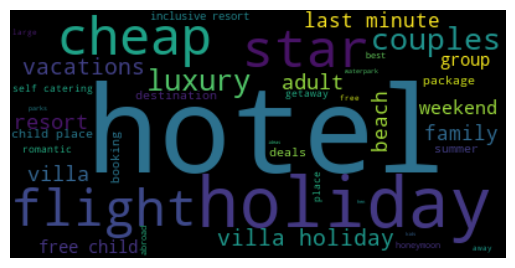

Most common words in cluster 0 (size: 235):
holidays hotel holiday star cheap villa couples luxury hotels resorts


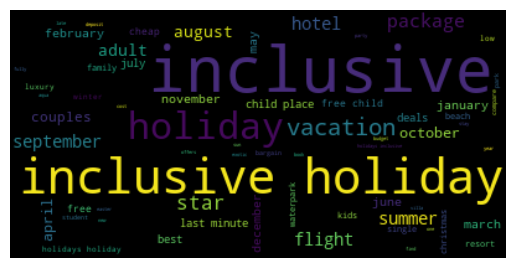

Most common words in cluster 1 (size: 342):
inclusive all holidays holiday 2023 in vacations 2024 star 2022


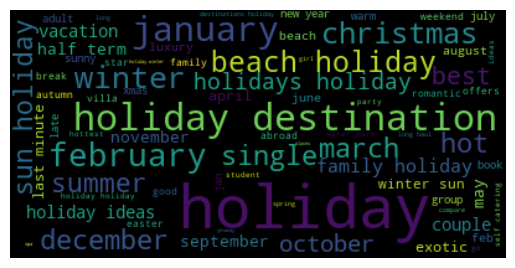

Most common words in cluster 2 (size: 737):
holidays holiday in destinations winter january beach february christmas sun


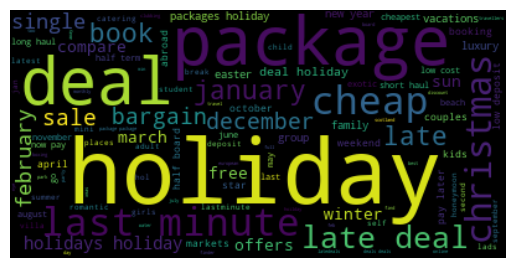

Most common words in cluster 3 (size: 291):
holiday holidays deals package packages late last cheap minute christmas


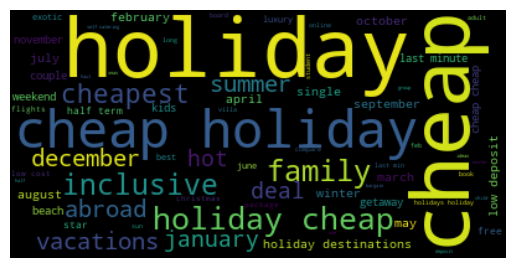

Most common words in cluster 4 (size: 453):
cheap holidays holiday in all family for inclusive cheapest 2023


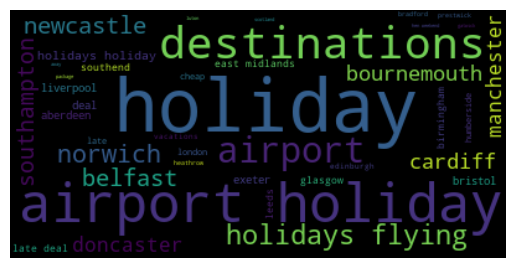

Most common words in cluster 5 (size: 212):
from holidays airport holiday destinations flying norwich deals late belfast


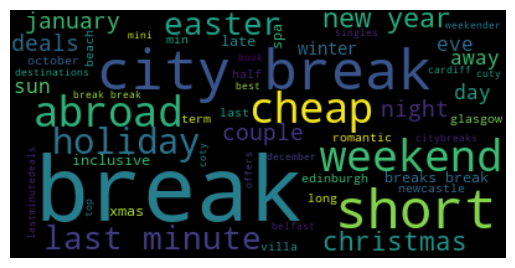

Most common words in cluster 6 (size: 128):
breaks break city short weekend cheap last abroad minute new


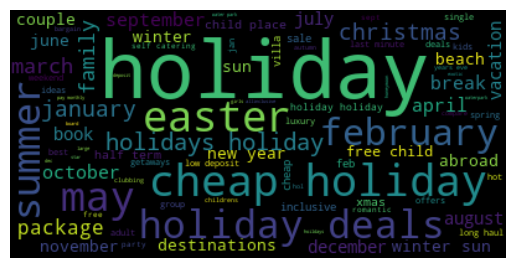

Most common words in cluster 7 (size: 996):
holidays 2023 holiday 2022 2024 in cheap easter deals may


In [56]:
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud

clustered = kmeans_clustered

for cluster in clustered.keys():
    wordcloud = WordCloud().generate(' '.join(clustered[cluster]))
    plt.figure()
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()
    count_vectorizer = CountVectorizer()
    count_vectorizer.fit(clustered[cluster])
    bow = count_vectorizer.transform(clustered[cluster])
    sum_words = bow.sum(axis=0)
    words_freq = [(word, sum_words[0, idx])
                  for word, idx in count_vectorizer.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    print('Most common words in cluster {} (size: {}):\n{}'.format(
        cluster, len(clustered[cluster]), ' '.join([w[0] for w in words_freq[:10]])))


# <a id='toc10_'></a>[Saving cluster data for forecasting](#toc0_)

In [57]:
processed_df['Cluster'] = processed_df[
    'Criteria_bmm_ignored'].map(
        lambda x: [k for k, v in clustered.items() if x in v][0])


In [58]:
forecast_data = {}
for cluster in clustered.keys():
    forecast_data[cluster] = processed_df.loc[
        processed_df['Cluster'] == cluster,
        features_date].groupby(by='Date').sum()
    forecast_data[cluster].to_csv(
        os.path.join(os.environ['PROCESSED_DATA_PATH'],
                     f'processed_{cluster}.csv'))


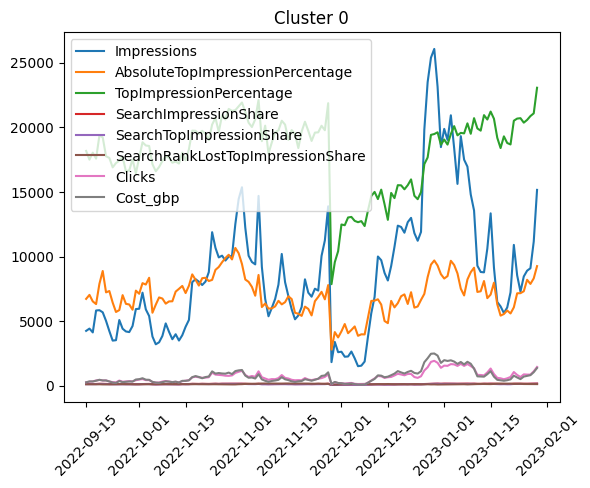

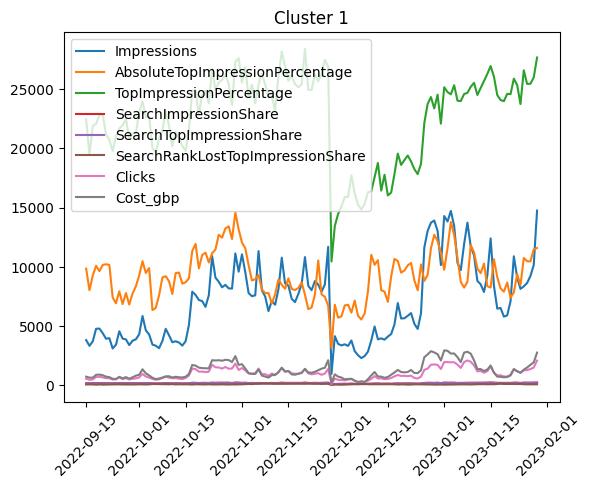

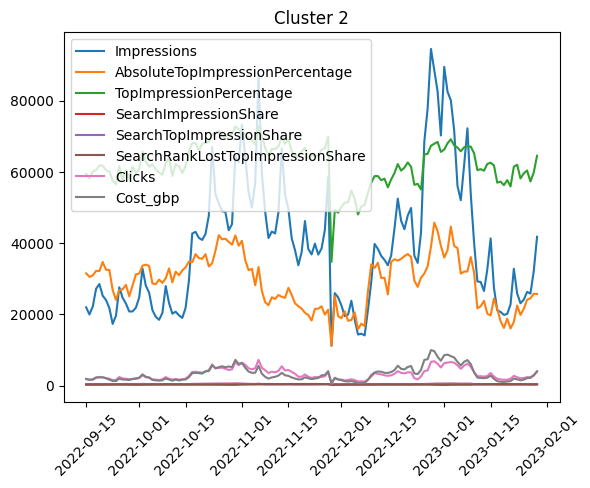

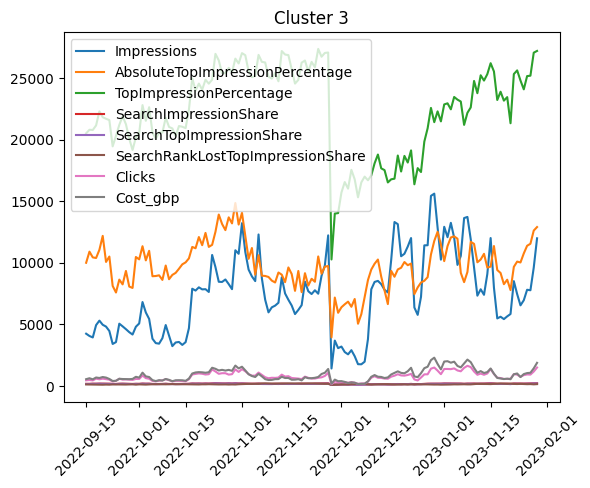

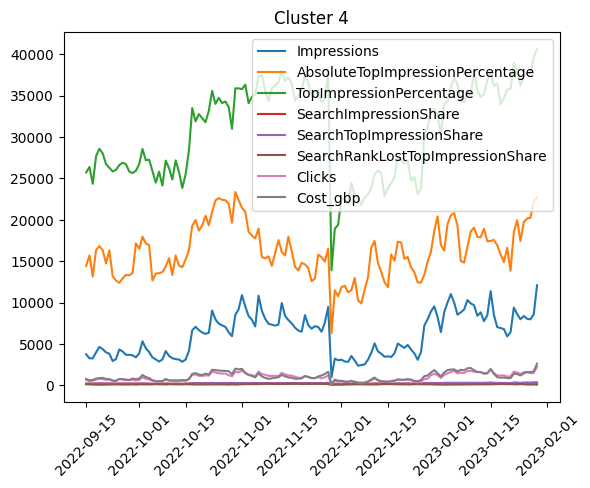

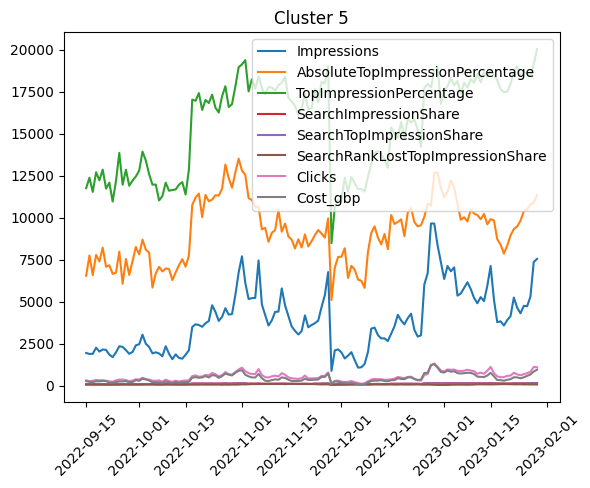

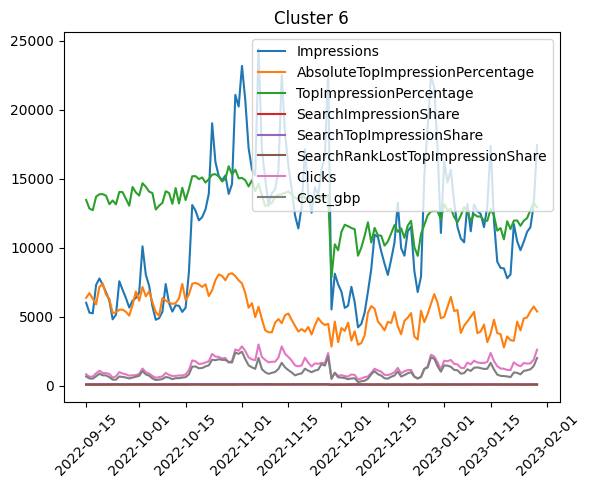

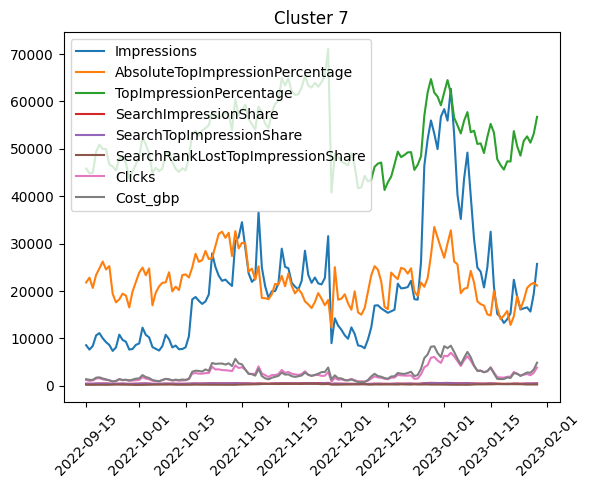

In [59]:
for cluster, df in forecast_data.items():
    plt.figure()
    plt.plot(df[features], label=features)
    plt.title(f'Cluster {cluster}')
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()

# <a id='toc12_'></a>[Work in progress](#toc0_)

In [150]:
# Topic extraction

In [151]:
# from bertopic import BERTopic

# topic_model = BERTopic(min_topic_size=50, top_n_words=5)
# topics, probs = topic_model.fit_transform(kwds_no_bmm)

In [152]:
# topic_model.get_topic_info()

In [153]:
# topic_model.visualize_topics()

In [154]:
# all_topics = topic_model.get_topics()


## <a id='toc12_1_'></a>[Visualise clusters with PCA](#toc0_)
Following the [sklearn example](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html#sphx-glr-auto-examples-cluster-plot-kmeans-digits-py)

In [155]:
# from sklearn.decomposition import PCA

# reduced_data = PCA(n_components=2).fit_transform(kwds_embeddings)
# kmeans_model_reduced = KMeans(n_clusters=n_clusters,
#                               max_iter=500,
#                               n_init=100,
#                               init='k-means++',
#                               random_state=SEED)
# kmeans_model_reduced.fit(reduced_data)

# h = 0.02
# x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
# y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
# xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
# Z = kmeans_model_reduced.predict(np.c_[xx.ravel(),
#                                        yy.ravel()].astype(np.float32))
# Z = Z.reshape(xx.shape)
# centroids = kmeans_model_reduced.cluster_centers_
# plt.imshow(Z,
#            interpolation='nearest',
#            extent=(xx.min(), xx.max(), yy.min(), yy.max()),
#            cmap=plt.cm.Pastel2)
# plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# plt.scatter(centroids[:, 0],
#             centroids[:, 1],
#             marker='x',
#             s=169,
#             linewidths=3,
#             color='w',
#             zorder=10)
